In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import math
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Image

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

import statsmodels.api as sm


#Code to always set working directory one level up so we can access /data easily
import os
if "NOTEBOOK_DIR" not in globals():
    NOTEBOOK_DIR = os.getcwd()
    print('Notebook Directory Set:', os.getcwd())

os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
print("Current working directory:", os.getcwd())

Notebook Directory Set: /shared_folder/eas_508_project/notebooks
Current working directory: /shared_folder/eas_508_project


In [2]:
pbp_path = 'data/interim/pbp/'

pbp_name = 'featured_11_11.csv'

df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})
shape = df.shape
columns = df.columns

print('✔✔✔ File Loaded\n')
print(f'Shape: {shape}\n')
print(f'Column Names: {list(columns)}\n')

df.head()

/tmp/ipykernel_88380/1051494428.py:5: DtypeWarning: Columns (84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})


✔✔✔ File Loaded

Shape: (307577, 106)

Column Names: ['nflverse_game_id', 'play_id', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'n_offense', 'n_defense', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'yrdln', 'ydstogo', 'ydsnet', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'run_location', 'run_gap', 'score_differential', 'no_score_prob', 'fg_prob', 'td_prob', 'ep', 'epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'wpa', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'penalty', 'field_goal_attempt', 'complete_pass', 'passing_yards', 'receiving_yards', 'rushing_yards', 'season', 'order_sequence', 'stadium', 'weather', 'nfl_api_id', 'fixed_drive'

,nflverse_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,n_offense,n_defense,home_team,...,bigs,personnel_num,ydstosuccess,previous_success,fp_success,smoothed_fp_success,fp_epa,f_success,smoothed_f_success,f_epa
0,2016_01_BUF_BAL,58,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,1,12,5.0,0.0,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042
1,2016_01_BUF_BAL,85,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,1,12,2.8,1.0,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173
2,2016_01_BUF_BAL,109,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,1,12,5.0,1.0,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173
3,2016_01_BUF_BAL,130,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,1,12,7.0,0.0,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042
4,2016_01_BUF_BAL,154,BAL,UNDER_CENTER,"1 RB, 2 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,2,21,1.0,1.0,0.420136,0.420369,0.006901,0.429168,0.429205,0.010042


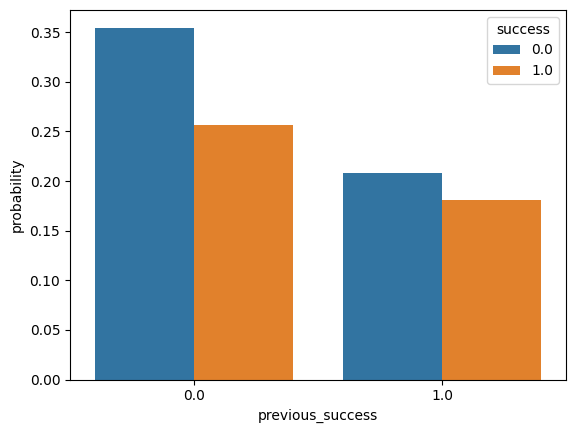

In [3]:
sns.countplot(data=df, x='previous_success', hue='success', stat='probability')
plt.show()

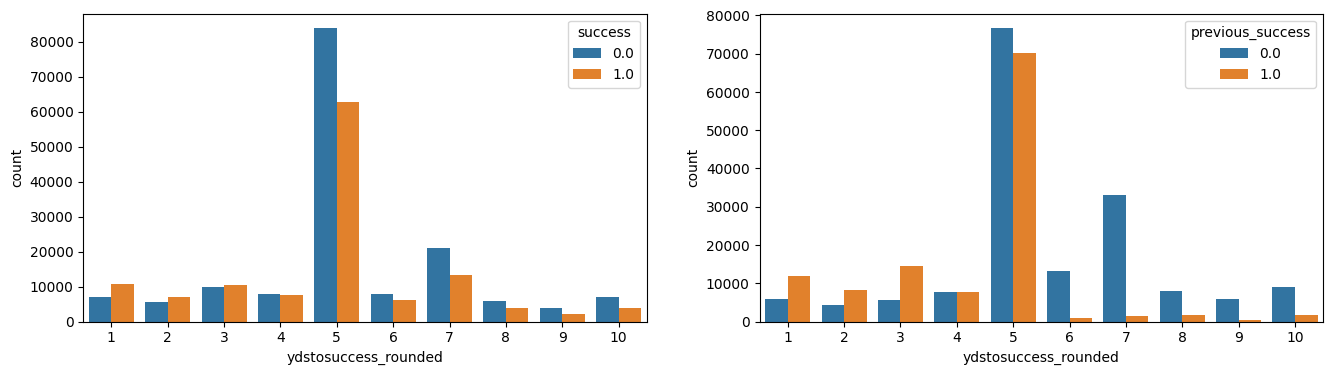

In [4]:
df['ydstosuccess_rounded'] = df['ydstosuccess'].apply(lambda x: math.ceil(x))

fig, axes = plt.subplots(1,2, figsize=(16,4))

sns.countplot(data=df[df['ydstosuccess_rounded']<11], x ='ydstosuccess_rounded', hue='success', ax=axes[0])
sns.countplot(data=df[df['ydstosuccess_rounded']<11], x ='ydstosuccess_rounded', hue='previous_success', ax=axes[1])

plt.show()

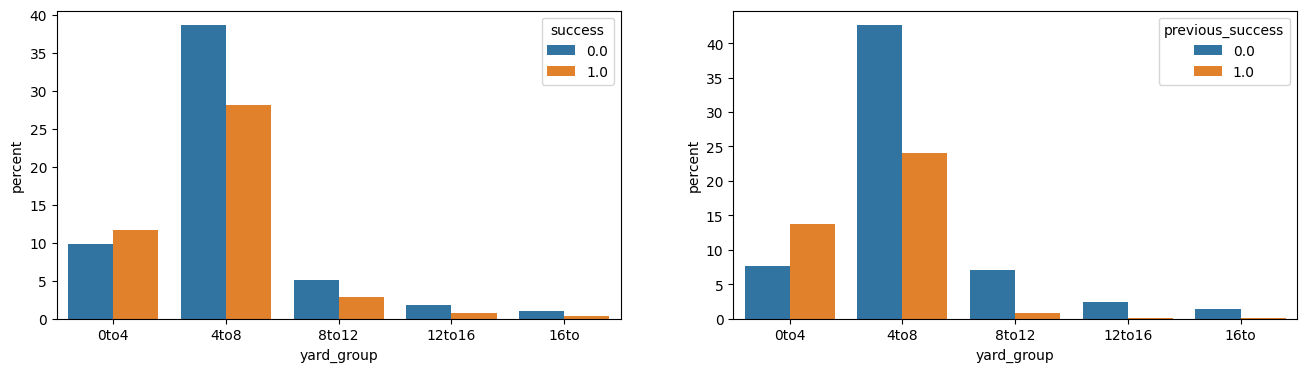

In [5]:
yard_bins = [0, 4, 8, 12, 16, np.inf]
yard_labels = ['0to4','4to8','8to12','12to16','16to']

df['yard_group'] = pd.cut(df['ydstosuccess_rounded'], bins=yard_bins, labels=yard_labels, right=True)

fig, axes = plt.subplots(1,2, figsize=(16,4))

sns.countplot(data=df, x ='yard_group', hue='success', stat='percent', ax=axes[0])
sns.countplot(data=df, x ='yard_group', hue='previous_success', stat='percent', ax=axes[1])

plt.show()

<Axes: xlabel='offense_formation', ylabel='fp_epa'>

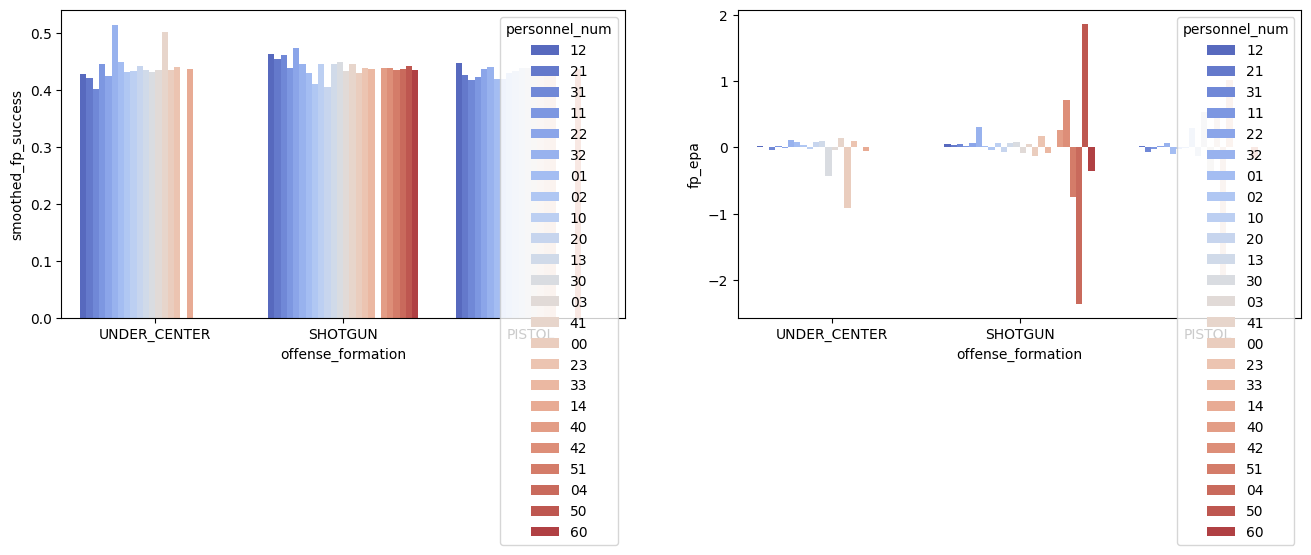

In [6]:
fig, axes = plt.subplots(1,2, figsize=(16,4))

sns.barplot(
    data=df,
    y='smoothed_fp_success',
    x='offense_formation',
    hue='personnel_num',
    ax=axes[0],
    palette='coolwarm'
)

sns.barplot(
    data=df,
    y='fp_epa',
    x='offense_formation',
    hue='personnel_num',
    ax=axes[1],
    palette='coolwarm'
)

In [7]:
view = df[['offense_formation','personnel_num','fp_epa','smoothed_fp_success']].groupby(['offense_formation','personnel_num']).mean()
view.head(60)

fp_epa  smoothed_fp_success
offense_formation personnel_num                               
PISTOL            00            -2.046756             0.435837
                  01            -0.093679             0.418291
                  02            -0.024449             0.418797
                  03            -0.351119             0.434028
                  10            -0.003804             0.429237
                  11            -0.024344             0.422071
                  12             0.007926             0.446715
                  13            -0.128761             0.438636
                  20             0.294007             0.433439
                  21             0.025375             0.426345
                  22             0.021628             0.435435
                  23             1.017408             0.437833
                  30             0.536139             0.437211
                  31            -0.077098             0.416439
                  32             0.069411             0.440219
                  41             0.586961             0.441411
                  42            -0.161966             0.435837
SHOTGUN           00            -0.129682             0.429659
                  01             0.016273             0.429187
                  02            -0.043114             0.409801
                  03            -0.078607             0.433071
                  04            -2.366416             0.436960
                  10             0.068575             0.445336
                  11             0.016268             0.438506
                  12             0.057628             0.462669
                  13             0.067838             0.445050
                  20            -0.076008             0.404958
                  21             0.039927             0.453214
                  22             0.059607             0.473608
                  23             0.176921             0.437705
                  30             0.074633             0.448342
                  31             0.053743             0.460995
                  32             0.312000             0.445237
                  33            -0.090707             0.435837
                  40             0.265801             0.437092
                  41             0.045980             0.444094
                  42             0.715278             0.437459
                  50             1.860049             0.441179
                  51            -0.744890             0.433768
                  60            -0.355398             0.434968
UNDER_CENTER      00            -0.911820             0.434365
                  01             0.076843             0.448038
                  02             0.036378             0.431505
                  03            -0.047112             0.434624
                  10            -0.028565             0.432964
                  11             0.024770             0.444458
                  12             0.019530             0.426601
                  13             0.099345             0.434326
                  14            -0.060207             0.435837
                  20             0.075844             0.441273
                  21             0.006901             0.420369
                  22            -0.009017             0.424193
                  23             0.092619             0.439049
                  30            -0.430506             0.430569
                  31            -0.043751             0.400372
                  32             0.114010             0.513560
                  41             0.140504             0.500847

In [8]:
df['personnel_num'].value_counts()

personnel_num
11    187355
21     62302
12     22961
31     14095
22      8354
01      4284
02      2335
10      2088
32      1404
20      1080
41       590
00       226
30       200
13       175
03        72
23        20
40        11
51         8
42         7
50         4
04         2
60         2
33         1
14         1
Name: count, dtype: Int64

In [12]:
df[df['personnel_num'] == '50']

,nflverse_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,n_offense,n_defense,home_team,...,ydstosuccess,previous_success,fp_success,smoothed_fp_success,fp_epa,f_success,smoothed_f_success,f_epa,ydstosuccess_rounded,yard_group
209358,2022_04_MIN_NO,3260,NO,SHOTGUN,"7 OL, 0 RB, 3 TE, 0 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,NO,...,1.0,1.0,1.0,0.441179,1.860049,0.441437,0.441424,0.021173,1,0to4
211623,2022_05_SEA_NO,177,NO,SHOTGUN,"7 OL, 0 RB, 3 TE, 0 WR",8.0,"3 DL, 4 LB, 4 DB",11,11,NO,...,1.0,1.0,1.0,0.441179,1.860049,0.441437,0.441424,0.021173,1,0to4
211682,2022_05_SEA_NO,2324,NO,SHOTGUN,"7 OL, 0 RB, 3 TE, 0 WR",8.0,"3 DL, 4 LB, 4 DB",11,11,NO,...,1.0,1.0,1.0,0.441179,1.860049,0.441437,0.441424,0.021173,1,0to4
211726,2022_05_SEA_NO,4083,NO,SHOTGUN,"7 OL, 0 RB, 3 TE, 0 WR",8.0,"3 DL, 4 LB, 4 DB",11,11,NO,...,1.0,0.0,1.0,0.441179,1.860049,0.441437,0.441424,0.021173,1,0to4


In [10]:
print("types now:", df['personnel_num'].apply(type).value_counts())
print("dtype now:", df['personnel_num'].dtype)
print(df[['bigs','RB','personnel_num']].head(10))

types now: personnel_num
<class 'str'>    307577
Name: count, dtype: int64
dtype now: string
   bigs  RB personnel_num
0     1   2            12
1     1   2            12
2     1   2            12
3     1   2            12
4     2   1            21
5     2   1            21
6     3   1            31
7     1   1            11
8     2   1            21
9     2   1            21
